In [405]:
# import sql engine, pandas, numpy
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime as dt

In [2]:
!ls


README.md                         rover.com-analytics-project.ipynb
db1.sqlite3


In [3]:
# the sqlite database can be converted to use postgresql using pgloader
# First you must have postgresql installed
# Then create an empty db to load the database into
# In this instance, I created a 'rover' db
# I used postgresql to explore the data set, but use python via pscopg to visualize the query result

# !pgloader db1.sqlite3 postgresql:///rover

# EXERCISES


# I. Exploring the Database

In [5]:
conn = psycopg2.connect('dbname=rover')
cur = conn.cursor()

### 1. How many users have signed up?

In [26]:
query =  '''
SELECT 
    COUNT(*)
FROM
	people_person;
    '''
cur.execute(query)

df_1= pd.read_sql_query(query,conn)
df_1

,count
0,64393


### 2. How many users signed up prior to 2018-02-03 ?

In [25]:
query =  '''
SELECT 
    COUNT(*)
FROM
	people_person
WHERE date_joined < '2018-02-03'    
    ;
    '''
df_2 = pd.read_sql_query(query,conn)
df_2

,count
0,35826


### 3. What percentage of users have added pets?
#### One thing to note, when dealing with percentages, either cast the numerator to a decimal/numeric, or just make the percentage conversion by using 100.0 (a float) vs 100 (a integer) to keep the precision

In [51]:
query='''
SELECT
    ROUND(count(distinct owner_id)*100.0/(SELECT COUNT(*) FROM people_person),2) as percentage
FROM 
    pets_pet;
'''
df_3= pd.read_sql_query(query,conn)
df_3

# this number gives me the number of users that have registered pets
# now to get a count of the total users, I just divide this number by the total found
# in question 1

,percentage
0,80.43


In [38]:
soln = df_3['count'] / df_1['count']

soln[0].round(4) *100

80.43

### 4. Of those users, how many pets have they added on average?

In [42]:
query ='''
SELECT
    ROUND(avg(count),3) as average_added_pets
FROM
    (
    SELECT 
        COUNT(id) as count, owner_id
    FROM 
        pets_pet
    GROUP BY 
        owner_id) as counts;'''
df_4 = pd.read_sql_query(query,conn)
df_4

,average_added_pets
0,1.501


### 5. What percentage of pets play well with cats?

In [56]:
query = '''
SELECT
ROUND(count(CASE WHEN plays_cats THEN 1 END)*100::decimal/ (SELECT COUNT(*) FROM pets_pet),2) as percentage
FROM pets_pet;
'''
df_5= pd.read_sql_query(query,conn)
df_5

,percentage
0,24.85


 ## III. Recent Daily Booking Rate
 #### The snapshot of this database was taken on 2018-08-02 at midnight and only contains data reflecting events prior to that date. A junior analyst is investigating daily booking rate during the days prior to the snapshot and is concerned about an apparent downward trend. You are tasked with helping them out. First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book.

####  Looking at the columns and table, to get the count of total conversations, we can use the start_date to indicate each and every conversation that takes place. A pet_owner can start conversations with many different providers, so we want to keep track of that.
 
To find the total of booked services, the simple method would be to just take the total number of 'booked_at' column divided by the total count of the table. We also want to account for bookeings that are cancelled. To keep it simple, we can just focus on bookings that are not cancelled.

In [225]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    id IN
        (SELECT 
            id
        FROM
            conversations_conversation
        WHERE
        (cancelled_at IS NULL))
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_1 = pd.read_sql_query(query,conn)
df_1

,date,conversion_rate
0,2018-05-04,42.58
1,2018-05-05,41.04
2,2018-05-06,42.79
3,2018-05-07,46.19
4,2018-05-08,36.79
...,...,...
85,2018-07-28,37.86
86,2018-07-29,31.09
87,2018-07-30,18.75
88,2018-07-31,12.42


In [223]:
df_1.describe()

,conversion_rate
count,90.000000
mean,40.257222
std,6.376938
min,4.930000
25%,38.837500
50%,41.140000
75%,42.940000
max,49.000000


During the 90 day period, the mean converstion_rate is ~ 40.26% with a standard deviation of ~6.37%

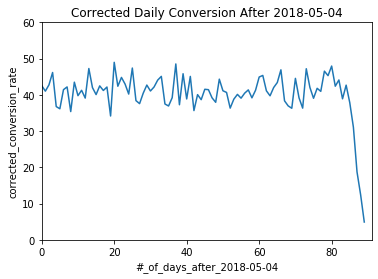

In [229]:
plt.figure(figsize=(10,4))
plt.plot(df_1['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,60)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,91)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

### 1. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?

In [182]:
df_1.describe()

,conversion_rate
count,90.000000
mean,40.257222
std,6.376938
min,4.930000
25%,38.837500
50%,41.140000
75%,42.940000
max,49.000000


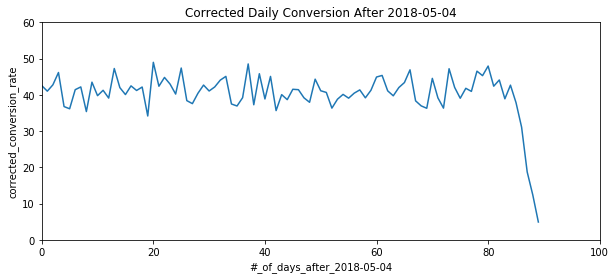

In [180]:
plt.figure(figsize=(10,4))
plt.plot(df_1['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,60)
plt.xlim(0,100)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

### 2. Can you narrate a reason why this trend exists? Is there a reason to be concerned? Please provide additional data and evidence to justify your position.

Although there does exist a negative trend for the converstion rate, one must simply keep in mind that the most recent bookings are for start dates that are in the future, and have not been fulfilled quite yet. 

By defining the daily booking rate to be the percentage of conversations created each day that eventually book, we are stil waiting for these most recent requests to be accepted by the service provider and that affects our conversion rate. Thus, we must redefine our metric to account for this.

#### BELOW is a query that eliminates future requests and narrows down to bookings with end_dates on the last day of data collection.

In [242]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    end_date < date'2018-08-02'
AND
    id IN
        (SELECT 
            id
        FROM
            conversations_conversation
        WHERE
        (cancelled_at IS NULL))
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_corrected_date = pd.read_sql_query(query,conn)
df_corrected_date

,date,conversion_rate
0,2018-05-04,42.58
1,2018-05-05,41.04
2,2018-05-06,42.79
3,2018-05-07,46.19
4,2018-05-08,36.79
...,...,...
76,2018-07-19,46.60
77,2018-07-20,49.18
78,2018-07-21,53.33
79,2018-07-22,47.62


In [227]:
df_corrected_date.describe()

,conversion_rate
count,81.000000
mean,41.613704
std,3.860461
min,34.190000
25%,38.890000
50%,41.280000
75%,44.090000
max,53.330000


Notice now, we have less days to account for, since the latest added date in our new query is 2018-07-25, with a new total of 81 days, with a mean converstion rate of ~41.61 with a standard deviation of ~3.86.

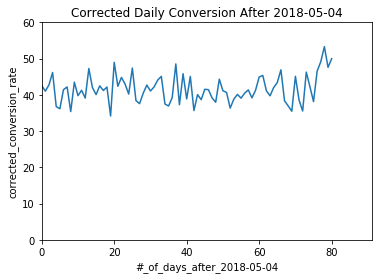

In [243]:
plt.figure(figsize=(10,4))
plt.plot(df_corrected_date['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,60)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,91)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

Now, compared to the graph of before...

### 

,conversion_rate
count,81.000000
mean,41.613704
std,3.860461
min,34.190000
25%,38.890000
50%,41.280000
75%,44.090000
max,53.330000


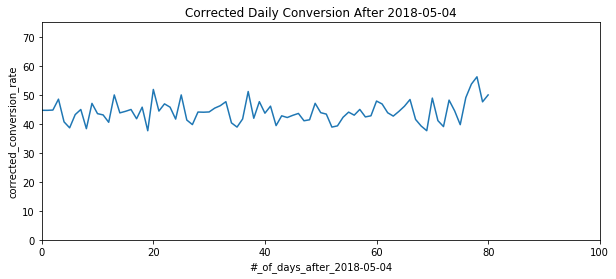

In [155]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    end_date < date'2018-08-02'
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_corrected_date = pd.read_sql_query(query,conn)
df_corrected_date
plt.figure(figsize=(10,4))
plt.plot(df_corrected_date['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,75)
plt.xlim(0,100)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

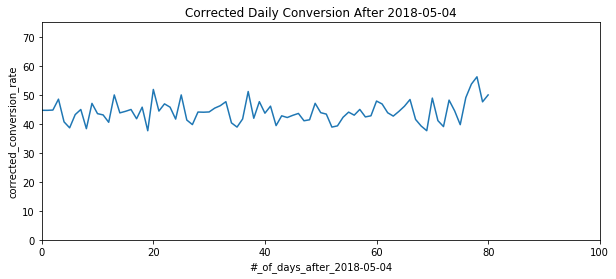

In [155]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    end_date < date'2018-08-02'
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_corrected_date = pd.read_sql_query(query,conn)
df_corrected_date
plt.figure(figsize=(10,4))
plt.plot(df_corrected_date['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,75)
plt.xlim(0,100)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

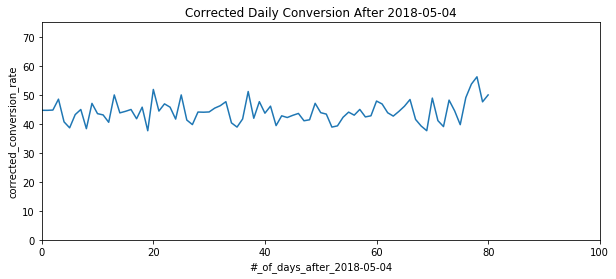

In [155]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    end_date < date'2018-08-02'
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_corrected_date = pd.read_sql_query(query,conn)
df_corrected_date
plt.figure(figsize=(10,4))
plt.plot(df_corrected_date['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,75)
plt.xlim(0,100)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

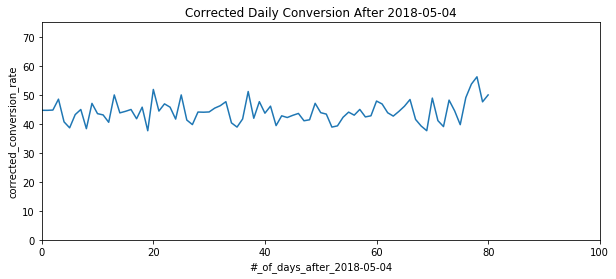

In [155]:
query = '''
SELECT 
    DATE(added) as date, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
WHERE 
    added > date '2018-08-02' - INTERVAL '90 days'
AND
    end_date < date'2018-08-02'
GROUP BY 
    date
ORDER BY
    date ASC;
'''
df_corrected_date = pd.read_sql_query(query,conn)
df_corrected_date
plt.figure(figsize=(10,4))
plt.plot(df_corrected_date['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,75)
plt.xlim(0,100)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

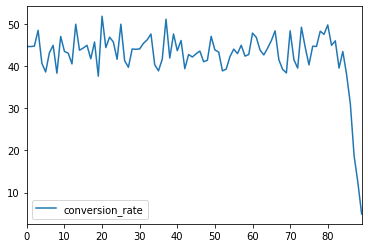

In [104]:
df.plot(y='conversion_rate',use_index=True,kind='line')

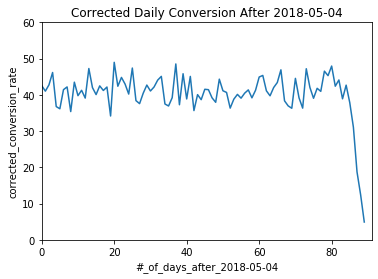

In [253]:
plt.figure(figsize=(10,4))
plt.plot(df_1['conversion_rate'])
plt.ylabel('corrected_conversion_rate')
plt.ylim(0,60)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,91)
plt.xlabel('#_of_days_after_2018-05-04')
plt.title('Corrected Daily Conversion After 2018-05-04')
plt.show();

By correctly defining our metric and narrowing down on bookings that have been completed. Although it does not account for bookings that might still be cancelled, the corrected conversion trend is not as bad as first perceived.

 ## IV. Analyzing Take Rate (IV)
 In order to do the next exercise, you will need to understand the fee structure for this company. Each user has a fee associated with their account (recorded on
people_person ). If that user books as an owner, the company charges a service fee (in addition to the booking total) that is a percentage of the booking total (to a maximum of \\$50).

Also, each service has a fee amount (recorded on services_service ). Before a provider receives their payment, the company takes a percentage of the booking total as dictated by that fee. As an example, suppose an owner has a fee amount of 5\% and books with a service that has a fee amount of 15\%. 

If the booking was for \\$100, then the owner would get charged \\$105 (adding the ownerʼs fee). The \\$5 owner fee would go to the company. An additional \\$15 would also go to the company since the service had a 15% fee associated to it. The remaining \\$85 would go to the provider. To summarize:

| | Amount | Description |
| --- | --- | --- |
| Booking Total |\$100 |  e.g., 4 walks at \$25/walk |
|  Owner Fee |\$5 |  5\% of the booking total |
| Gross Billings |\$105 |  charged to the owner |
| Service Fee |\$15 |  15\% of the booking total|
| Net Revenue |\$20 |  all fees that go to the company
| Provider Payment |\$85 |  earnings for the provider


### 1. In each month, what were the gross billings and net revenue?

First, let's find the total of bookings that are are completed

In [267]:
query='''
SELECT 
    *
FROM 
    conversations_conversation as cc
WHERE
    booked_at IS NOT NULL
AND
    cancelled_at IS NULL
;'''
df_completed = pd.read_sql_query(query,conn)
df_completed.head()

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,6,2018-07-04,2018-07-07,3,2018-06-23 16:16:16.891344-07:00,78,None,64388,14772,2018-06-27 14:39:51.433544-07:00,None
1,7,2018-07-31,2018-08-04,4,2018-07-21 04:55:57.951572-07:00,100,None,64386,14783,2018-07-22 02:50:20.676664-07:00,None
2,9,2018-07-02,2018-07-03,1,2018-06-21 06:23:08.092389-07:00,23,None,64384,7656,2018-06-23 01:49:33.596667-07:00,None
3,11,2018-06-12,2018-06-18,6,2018-06-03 09:11:33.421951-07:00,300,None,64382,2512,2018-06-07 01:24:20.187356-07:00,None
4,13,2018-07-24,2018-07-27,3,2018-07-13 10:30:05.875588-07:00,126,None,64381,1634,2018-07-19 01:01:11.552880-07:00,None


In [268]:
df_completed.shape[0]

30093

In [269]:
print(f'THERE are {df_completed.shape[0]} completed bookings in the dataset')

THERE are 30093 completed bookings in the dataset


Now, we want to add: 
- people_person pp.fee to get the owner fee which is a a decial form. To join it to our table, we can use conversations_conversation cc.requester_id on pp.id
- services_service ss.price for the price, and ss.fee to get the fee we gain from the total booking. To join this ss to cc, we can use cc.service_id = ss.id
- THEN SOME MATHS

In [309]:
query='''
WITH CTE 
AS 
(SELECT 
    EXTRACT(YEAR FROM booked_at) as year,
    EXTRACT(MONTH FROM booked_at) as month,
    cc.service_id,
    cc.requester_id,
    cc.booking_total as booking_total,
    pp.fee as owner_fee_perc, 
    (cc.booking_total * pp.fee) as owner_fee,
    (cc.booking_total + cc.booking_total * pp.fee) as gross_billings,
    ss.fee as service_fee_perc,
    ss.fee * cc.booking_total as service_fee,
    ((ss.fee * cc.booking_total) + (cc.booking_total*pp.fee)) as net_revenue,
    booking_total - ss.fee * cc.booking_total as provider_payment
FROM 
    conversations_conversation as cc
JOIN
    services_service ss ON cc.service_id = ss.id
JOIN
    people_person pp ON pp.id = cc.requester_id
WHERE
    cc.booked_at IS NOT NULL
AND
    cc.cancelled_at IS NULL)
SELECT 
 year,month, SUM(net_revenue) as net_revenue, SUM(gross_billings) as gross_billings
FROM cte
GROUP BY
    year, month
ORDER BY year ASC
;

;'''
df_revenue = pd.read_sql_query(query,conn)
df_revenue

,year,month,net_revenue,gross_billings
0,2016.0,8.0,635.12,3810.72
1,2016.0,9.0,2746.35,16478.10
2,2016.0,10.0,4805.56,28833.36
3,2016.0,11.0,6402.37,38414.22
4,2016.0,12.0,8575.93,51103.98
5,2017.0,1.0,12943.49,69952.14
6,2017.0,2.0,15410.61,82967.76
7,2017.0,3.0,21550.51,115218.81
8,2017.0,4.0,22890.05,122019.60
9,2017.0,5.0,28323.93,150345.78


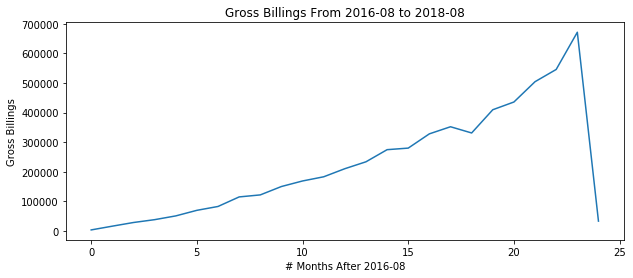

In [310]:
plt.figure(figsize=(10,4))
plt.plot(df_revenue['gross_billings'])
plt.ylabel('Gross Billings')
plt.xlabel('# Months After 2016-08')
plt.title('Gross Billings From 2016-08 to 2018-08')
plt.show();

### 2. Define take rate to be the percentage of gross billings that is net revenue. Inthe previous example, the take rate is slightly more than 19\% since 20 /105 is approximately 0.1905. In each month, what was the aggregate take rate?

In [277]:
query='''
WITH CTE 
AS 
(SELECT 
    EXTRACT(YEAR FROM booked_at) as year,
    EXTRACT(MONTH FROM booked_at) as month,
    cc.service_id,
    cc.requester_id,
    cc.booking_total as booking_total,
    pp.fee as owner_fee_perc, 
    (cc.booking_total * pp.fee) as owner_fee,
    (cc.booking_total + cc.booking_total * pp.fee) as gross_billings,
    ss.fee as service_fee_perc,
    ss.fee * cc.booking_total as service_fee,
    ((ss.fee * cc.booking_total) + (cc.booking_total*pp.fee)) as net_revenue,
    booking_total - ss.fee * cc.booking_total as provider_payment
FROM 
    conversations_conversation as cc
JOIN
    services_service ss ON cc.service_id = ss.id
JOIN
    people_person pp ON pp.id = cc.requester_id
WHERE
    cc.booked_at IS NOT NULL
AND
    cc.cancelled_at IS NULL)
SELECT 
 year,month, ROUND(SUM(net_revenue) *100 / SUM(gross_billings),2) as take_rate
FROM cte
GROUP BY
    year, month
ORDER BY year ASC;
;'''
df_take_rate = pd.read_sql_query(query,conn)
df_take_rate

,year,month,take_rate
0,2016.0,8.0,16.67
1,2016.0,9.0,16.67
2,2016.0,10.0,16.67
3,2016.0,11.0,16.67
4,2016.0,12.0,16.78
5,2017.0,1.0,18.50
6,2017.0,2.0,18.57
7,2017.0,3.0,18.70
8,2017.0,4.0,18.76
9,2017.0,5.0,18.84


### 3. Did take rate trend up or trend down or remain unchanged over time?
Let's Plot it!

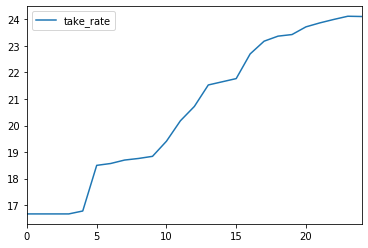

In [289]:
df_take_rate.plot(y='take_rate')

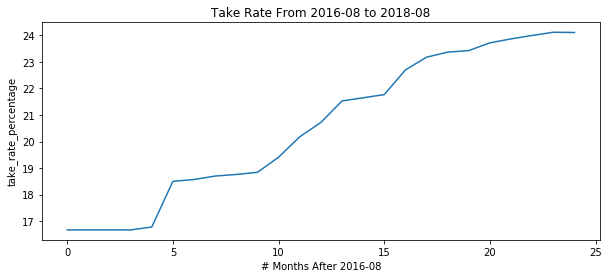

In [304]:
plt.figure(figsize=(10,4))
plt.plot(df_take_rate['take_rate'])
plt.ylabel('take_rate_percentage')
plt.xlabel('# Months After 2016-08')
plt.title('Take Rate From 2016-08 to 2018-08')
plt.show();

It most definetely increased!

### 4. If it did change, investigate why and provide an explanation. Be sure to provide additional data/charts/evidence that justify your explaination. Any claims should be backed by data.

Let's see if Gross Billings and Net Revenue is also increasing. Lets also truncate the data so that the last month of August 2018 is not accounted for since it is not complete.


In [319]:
query='''
WITH CTE 
AS 
(SELECT 
    EXTRACT(YEAR FROM booked_at) as year,
    EXTRACT(MONTH FROM booked_at) as month,
    cc.service_id,
    cc.requester_id,
    cc.booking_total as booking_total,
    pp.fee as owner_fee_perc, 
    (cc.booking_total * pp.fee) as owner_fee,
    (cc.booking_total + cc.booking_total * pp.fee) as gross_billings,
    ss.fee as service_fee_perc,
    ss.fee * cc.booking_total as service_fee,
    ((ss.fee * cc.booking_total) + (cc.booking_total*pp.fee)) as net_revenue,
    booking_total - ss.fee * cc.booking_total as provider_payment
FROM 
    conversations_conversation as cc
JOIN
    services_service ss ON cc.service_id = ss.id
JOIN
    people_person pp ON pp.id = cc.requester_id
WHERE
    cc.booked_at IS NOT NULL
AND
    cc.cancelled_at IS NULL
AND
    cc.booked_at < date'2018-08-01' )
SELECT 
 year,month, SUM(net_revenue) as net_revenue, SUM(gross_billings) as gross_billings
FROM cte
GROUP BY
    year, month
ORDER BY year ASC
;

;'''
df_revenue2 = pd.read_sql_query(query,conn)
df_revenue2

,year,month,net_revenue,gross_billings
0,2016.0,8.0,635.12,3810.72
1,2016.0,9.0,2746.35,16478.10
2,2016.0,10.0,4805.56,28833.36
3,2016.0,11.0,6402.37,38414.22
4,2016.0,12.0,8575.93,51103.98
5,2017.0,1.0,12943.49,69952.14
6,2017.0,2.0,15410.61,82967.76
7,2017.0,3.0,21550.51,115218.81
8,2017.0,4.0,22890.05,122019.60
9,2017.0,5.0,28323.93,150345.78


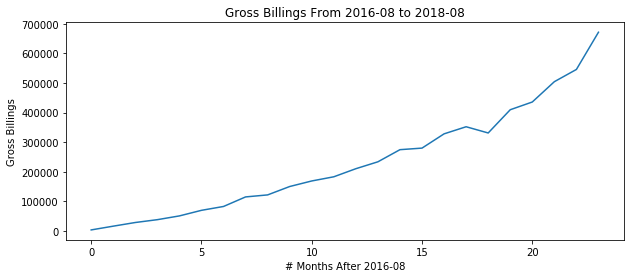

In [312]:
plt.figure(figsize=(10,4))
plt.plot(df_revenue2['gross_billings'])
plt.ylabel('Gross Billings')
plt.xlabel('# Months After 2016-08')
plt.title('Gross Billings From 2016-08 to 2018-08')
plt.show();

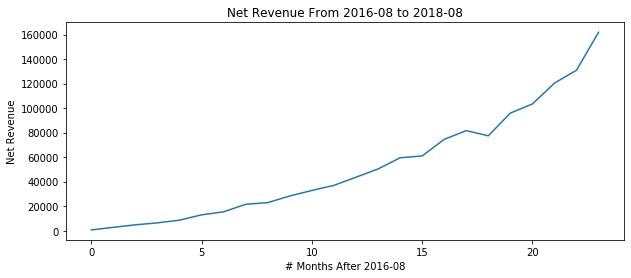

In [320]:
plt.figure(figsize=(10,4))
plt.plot(df_revenue2['net_revenue'])
plt.ylabel('Net Revenue')
plt.xlabel('# Months After 2016-08')
plt.title('Net Revenue From 2016-08 to 2018-08')
plt.show();

Yes, both are increasing.

Let's also explore the number of services and their growth, and also the number of users. 

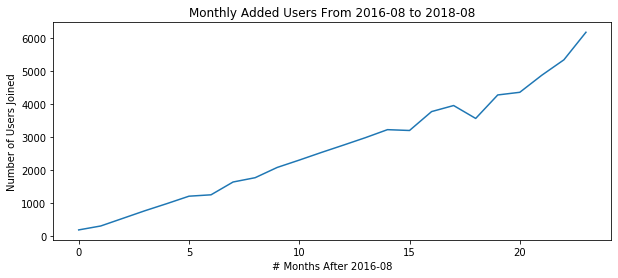

In [321]:
query=''' 
WITH CTE 
AS 
(SELECT 
    EXTRACT(YEAR FROM date_joined) as year,
    EXTRACT(MONTH FROM date_joined) as month,
 	id as id
 FROM
 	people_person
WHERE
	date_joined < date('2018-08-01'))
SELECT 
 COUNT(id) as total_users_joined
FROM cte
GROUP BY
    year, month
ORDER BY year ASC;
'''
df_user_growth = pd.read_sql_query(query,conn)
plt.figure(figsize=(10,4))
plt.plot(df_user_growth['total_users_joined'])
plt.ylabel('Number of Users Joined')
plt.xlabel('# Months After 2016-08')
plt.title('Monthly Added Users From 2016-08 to 2018-08')
plt.show();

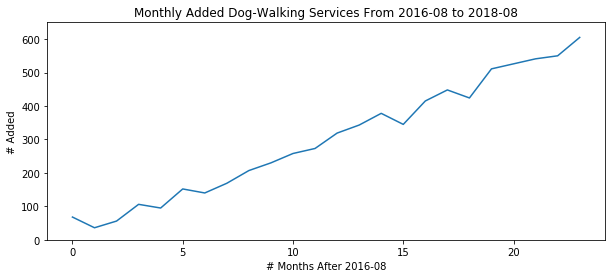

In [329]:
query = '''
WITH CTE AS
(SELECT 
    EXTRACT(YEAR FROM added) as year,
    EXTRACT(MONTH FROM added) as month,
    service_type
FROM
    services_service
WHERE added < date '2018-08-01')
SELECT year, month, service_type, COUNT(service_type) as count
FROM cte
WHERE service_type = 'dog-walking'
GROUP BY 
    year, month, service_type
ORDER BY
    year ASC, month;'''
df_dog_walking = pd.read_sql_query(query,conn)
plt.figure(figsize=(10,4))
plt.plot(df_dog_walking['count'])
plt.ylabel('# Added')
plt.ylim(0,650)
plt.xlabel('# Months After 2016-08')
plt.title('Monthly Added Dog-Walking Services From 2016-08 to 2018-08')
plt.show();

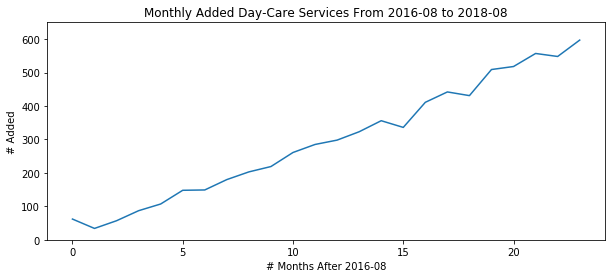

In [330]:
query = '''
WITH CTE AS
(SELECT 
    EXTRACT(YEAR FROM added) as year,
    EXTRACT(MONTH FROM added) as month,
    service_type
FROM
    services_service
WHERE added < date '2018-08-01')
SELECT year, month, service_type, COUNT(service_type) as count
FROM cte
WHERE service_type = 'day-care'
GROUP BY 
    year, month, service_type
ORDER BY
    year ASC, month;'''
df_day_care = pd.read_sql_query(query,conn)
plt.figure(figsize=(10,4))
plt.plot(df_day_care['count'])
plt.ylim(0,650)
plt.ylabel('# Added')
plt.xlabel('# Months After 2016-08')
plt.title('Monthly Added Day-Care Services From 2016-08 to 2018-08')
plt.show();

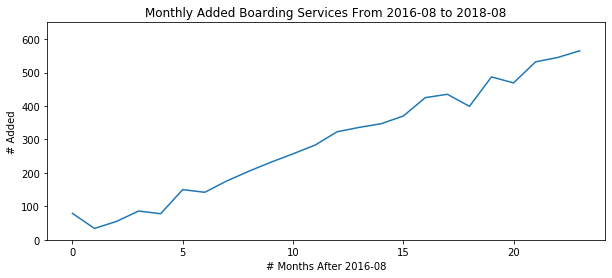

In [374]:
query = '''
WITH CTE AS
(SELECT 
    EXTRACT(YEAR FROM added) as year,
    EXTRACT(MONTH FROM added) as month,
    service_type
FROM
    services_service
WHERE added < date '2018-08-01')
SELECT year, month, service_type, COUNT(service_type) as count
FROM cte
WHERE service_type = 'boarding'
GROUP BY 
    year, month, service_type
ORDER BY
    year ASC, month;'''
df_boarding = pd.read_sql_query(query,conn)
plt.figure(figsize=(10,4))
plt.plot(df_boarding['count'])
plt.ylim(0,650)
plt.ylabel('# Added')
plt.xlabel('# Months After 2016-08')
plt.title('Monthly Added Boarding Services From 2016-08 to 2018-08')
plt.show();

### The key take away is that the data above shows that the company itself is growing. The growth in number of users added and the number of services leads to the potential of more bookings to be completed, thus attributing to increases in Net Revenue and Gross Billings.

 ## VI. Search Engine Marketing (VI).

#### Search engine advertising is a huge driver of new user accounts. Users that are aquired through search engine marketing can be identified by looking at people_person.channel . These users will have 'Google' listed there. <br><br> Historically, this company spent an average of \\$30 per account to advertise in the 2nd position on Google. <br><br> However, on 2018-05-04 , they decided to start bidding for the 1st position. Since 2018-05-04 , they have spent \\$207180 in total.

### 1. For each day,determine the count of users that joined and were acquired through Google. Plot this and confirm there is an inflection point on or near 2018-05-04 .

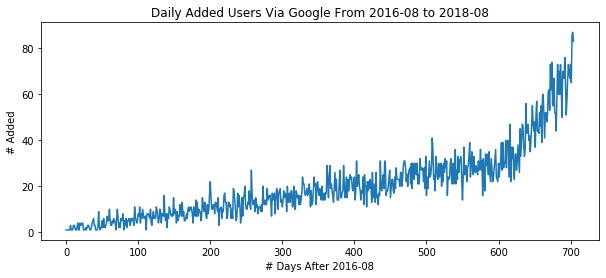

In [334]:
query='''
SELECT
    DATE(date_joined) as date, count(id) as count, channel
FROM
    people_person
WHERE 
    channel='Google'
GROUP BY
    channel, date
ORDER BY
    date
'''
df_google = pd.read_sql_query(query,conn)
plt.figure(figsize=(10,4))
plt.plot(df_google['count'])
plt.ylabel('# Added')
plt.xlabel('# Days After 2016-08')
plt.title('Daily Added Users Via Google From 2016-08 to 2018-08')
plt.show();

It appears there is an inflection point.

### 2. How many users were acquired via Google advertising since 2018-05-04 and what was the average cost per account?

First, we need to find the number of users added via google and multiply that by 30 to get the cost and number of users added before 2018-05-04.

In [347]:
query = '''
SELECT
    COUNT(*)
FROM
    people_person
WHERE 
    channel='Google'
;'''
df_sum_google = pd.read_sql_query(query,conn)
df_sum_google

,count
0,14262


In [348]:
sum_google_users = df_sum_google.loc[0][0]

In [352]:
query = '''
SELECT
    COUNT(*)
FROM
    people_person
WHERE 
    channel='Google'
AND
    date_joined < DATE '2018-05-04'
;'''
df_users_before_may = pd.read_sql_query(query,conn)
df_users_before_may

,count
0,9658


In [353]:
sum_users_before_may = df_users_before_may.loc[0][0]

In [354]:
sum_since_may = sum_google_users - sum_users_before_may

sum_since_may

4604

In [376]:
print(f'The number of users aquired via Google since 2018-05-04 is {sum_since_may},\n'
      f'with an average ${207180/sum_since_may} spent per user.\n'
      f'This is an increase of {((45-30)/30)*100}% in spending before the inflection.')

The number of users aquired via Google since 2018-05-04 is 4604,
with an average $45.0 spent per user.
This is an increase of 50.0% in spending before the inflection.


### 3. Estimate how many users would have been aquired had the company not changed it's bidding strategy. What would have been the marketing spend in that case?

Let's find out the growth before 2018-05-04, find the regression of the growth, then estimate how many more users would have been added.

In [375]:
query = '''
SELECT
    id
FROM
    people_person
WHERE 
    channel='Google'
AND
    date_joined < DATE '2018-05-04'
ORDER BY 
;'''
df_users_before_may = pd.read_sql_query(query,conn)
df_users_before_may

<method 'date' of 'datetime.datetime' objects>

In [387]:
d0 = dt(2018,8,2)
d1 = dt(2018,5,4)

In [388]:
delta = d0-d1

In [389]:
delta.days

90

In [392]:
print(f'The number of days after 2018-05-04 is {delta.days} days')

The number of days after 2018-05-04 is 90 days


Let's consider daily growth so can group the number of users added via Google daily. 

In [398]:
query='''
SELECT
    DATE(date_joined) as date, count(id) as count, channel
FROM
    people_person
WHERE 
    channel='Google'
AND
    date_joined < DATE '2018-05-04'
GROUP BY
    date, channel
ORDER BY
    date
;'''
df_growth_google = pd.read_sql_query(query,conn)
df_growth_google

,date,count,channel
0,2016-08-08,1,Google
1,2016-08-09,1,Google
2,2016-08-10,1,Google
3,2016-08-11,1,Google
4,2016-08-12,1,Google
...,...,...,...
610,2018-04-29,40,Google
611,2018-04-30,28,Google
612,2018-05-01,36,Google
613,2018-05-02,40,Google


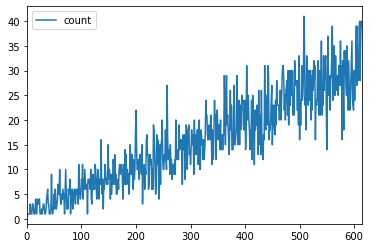

In [395]:
df_growth_google.plot()

It appears to be growing linearly, so let's apply a linear regression.

In [402]:
import statsmodels.api as sm

In [ ]:
y = df_growth_google['count']
x = 

In [399]:
df_growth_google.index

RangeIndex(start=0, stop=615, step=1)

In [406]:

x = df_growth_google.index
y = df_growth_google["count"]

# Note the difference in argument order
model = sm.OLS(y, x).fit()

predictions = model.predict(x) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                          1.232e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):                        0.00
Time:                        20:55:00   Log-Likelihood:                         -1723.7
No. Observations:                 615   AIC:                                      3449.
Df Residuals:                     614   BIC:                                      3454.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0504      0.000    110.982      0.000       0.050       0.051
==============================================================================
Omnibus:                        8.798   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               13.329
Skew:                           0.060   Prob(JB):                      0.00128
Kurtosis:                       3.711   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [407]:
model.predict(705)

array([35.52974322])